# Tugas Besar (Capstone) – Pemodelan & Simulasi Penyebaran Penyakit  
## Model SIR + Metode Runge–Kutta Orde 4 (RK4) pada Data COVID-19 India

**Kasus:** Pemodelan dan simulasi penyebaran penyakit menggunakan model **SIR** berbasis **persamaan diferensial (ODE)**, diselesaikan secara numerik dengan **Runge–Kutta Orde 4 (RK4)**.

**Pipeline (Modul 15 – Jalur 1 Sistem Dinamis/Kontinu):**  
**Load Data → EDA Time Series → Formulasi Model (ODE) → Implementasi Numerik (Euler + RK4) → Estimasi Parameter → Validasi (Grafik & Metrik) → Deployment Streamlit + Video Demo**

---

## Dataset
Sumber dataset: Kaggle – *covid19-in-india* (Sudalai Raj Kumar)  
https://www.kaggle.com/datasets/sudalairajkumar/covid19-in-india

File: `covid19.csv`

Kolom utama:
- `Date`
- `State/UnionTerritory`
- `Confirmed` (kumulatif)
- `Cured` (kumulatif)
- `Deaths` (kumulatif)

---

## Definisi Observasi untuk SIR
Karena dataset tidak menyediakan S secara langsung:
- **I_obs(t)** = `Active = Confirmed - Cured - Deaths`
- **R_obs(t)** = `Removed = Cured + Deaths`
- **S_obs(t)** = `N - I_obs(t) - R_obs(t)`

---

## Pemilihan Jalur (Kontinu vs Diskrit)
Kasus wabah COVID-19 dimodelkan sebagai perubahan jumlah populasi S, I, R terhadap waktu secara **kontinu** (perubahan terjadi setiap saat, tidak hanya pada event diskrit).  
Karena itu digunakan **persamaan diferensial (ODE)** untuk memodelkan dinamika sistem dan diselesaikan dengan metode numerik (Euler & RK4).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, sys, platform

# display() fallback agar aman di non-jupyter
try:
    from IPython.display import display
except Exception:
    def display(x):
        print(x)

# Opsional: ADF test
try:
    from statsmodels.tsa.stattools import adfuller
    HAS_STATSMODELS = True
except Exception:
    HAS_STATSMODELS = False

# Opsional: SciPy optimize
try:
    from scipy.optimize import minimize
    HAS_SCIPY = True
except Exception:
    HAS_SCIPY = False

print("Python:", sys.version.split()[0])
print("Platform:", platform.platform())
print("Has statsmodels:", HAS_STATSMODELS)
print("Has scipy:", HAS_SCIPY)

Python: 3.11.8
Platform: Windows-10-10.0.26200-SP0
Has statsmodels: True
Has scipy: True


## 0) Load Data
Tahap ini membaca dataset dan memastikan kolom wajib tersedia.

In [ ]:
DATA_PATHS = ["covid19.csv"]
DATA_PATH = next((p for p in DATA_PATHS if os.path.exists(p)), None)

if DATA_PATH is None:
    raise FileNotFoundError(
        "Tidak menemukan 'covid19.csv'. Pastikan file ada di folder notebook atau /mnt/data/."
    )

df_raw = pd.read_csv(DATA_PATH)

# rapikan nama kolom
df_raw.columns = [c.strip() for c in df_raw.columns]

required_cols = {"Date", "Confirmed", "Cured", "Deaths"}
missing = required_cols - set(df_raw.columns)
if missing:
    raise ValueError(
        f"Kolom wajib tidak ditemukan: {missing}. "
        f"Kolom yang tersedia: {list(df_raw.columns)}"
    )

# rapikan nama state bila ada
if "State/UnionTerritory" in df_raw.columns:
    df_raw["State/UnionTerritory"] = df_raw["State/UnionTerritory"].astype(str).str.strip()
else:
    print("Warning: kolom 'State/UnionTerritory' tidak ditemukan → hanya bisa scope 'All India'.")

display(df_raw.head())
print("Jumlah baris:", len(df_raw))
print("Kolom:", list(df_raw.columns))

,Sno,Date,Time,State/UnionTerritory,ConfirmedIndianNational,ConfirmedForeignNational,Cured,Deaths,Confirmed
0,1,2020-01-30,6:00 PM,Kerala,1,0,0,0,1
1,2,2020-01-31,6:00 PM,Kerala,1,0,0,0,1
2,3,2020-02-01,6:00 PM,Kerala,2,0,0,0,2
3,4,2020-02-02,6:00 PM,Kerala,3,0,0,0,3
4,5,2020-02-03,6:00 PM,Kerala,3,0,0,0,3


Jumlah baris: 999
Kolom: ['Sno', 'Date', 'Time', 'State/UnionTerritory', 'ConfirmedIndianNational', 'ConfirmedForeignNational', 'Cured', 'Deaths', 'Confirmed']


## 1) Data Cleaning & Agregasi Time Series

Output yang dihasilkan:
- Confirmed, Cured, Deaths (kumulatif)
- Active = I_obs (kasus aktif)
- Removed = R_obs (sembuh + meninggal)

Scope yang didukung:
- "All India" (agregasi seluruh state per tanggal)
- atau 1 state tertentu

In [3]:
df = df_raw.copy()

# --- rapikan nama kolom & state ---
df.columns = [c.strip() for c in df.columns]
if "State/UnionTerritory" in df.columns:
    df["State/UnionTerritory"] = df["State/UnionTerritory"].astype(str).str.strip()

# --- pastikan kolom wajib ada ---
required_cols = {"Date", "Confirmed", "Cured", "Deaths"}
missing = required_cols - set(df.columns)
if missing:
    raise ValueError(f"Kolom wajib tidak ditemukan: {missing}. Kolom tersedia: {list(df.columns)}")

# --- parsing tanggal robust ---
d1 = pd.to_datetime(df["Date"], errors="coerce")
if float(d1.isna().mean()) > 0.2:
    d2 = pd.to_datetime(df["Date"], errors="coerce", dayfirst=True)
    df["Date"] = d2 if float(d2.isna().mean()) < float(d1.isna().mean()) else d1
else:
    df["Date"] = d1

df = df.dropna(subset=["Date"])

# ✅ REVISI WAJIB: pastikan data terurut waktu sebelum agregasi
df = df.sort_values("Date")

# --- paksa numerik ---
for c in ["Confirmed", "Cured", "Deaths"]:
    df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0.0)

# =========================
# PILIH SCOPE
# =========================
SCOPE = "All India"   # ganti: "Maharashtra", "Kerala", dll
SCOPE = str(SCOPE).strip()

# =========================
# AGREGASI ANTI DOUBLE-COUNT (PENTING)
# Karena data kumulatif → ambil MAX dulu per (Date, State)
# =========================
if "State/UnionTerritory" in df.columns:
    by_state = (
        df.groupby(["Date", "State/UnionTerritory"])[["Confirmed", "Cured", "Deaths"]]
          .max()
          .sort_index()
    )

    if SCOPE == "All India":
        ts = by_state.groupby("Date")[["Confirmed", "Cured", "Deaths"]].sum().sort_index()
    else:
        if SCOPE not in df["State/UnionTerritory"].unique():
            raise ValueError(f"SCOPE='{SCOPE}' tidak ditemukan di kolom State/UnionTerritory.")
        ts = by_state.xs(SCOPE, level="State/UnionTerritory").sort_index()
else:
    if SCOPE != "All India":
        raise ValueError("Dataset tidak punya kolom State/UnionTerritory → scope hanya All India.")
    ts = df.groupby("Date")[["Confirmed", "Cured", "Deaths"]].max().sort_index()

# ✅ WAJIB: pastikan nilai kumulatif tidak pernah turun
for c in ["Confirmed", "Cured", "Deaths"]:
    ts[c] = ts[c].cummax()

# ✅ REVISI WAJIB: pastikan index tanggal rapi (harian) supaya diff/rolling/ODE konsisten
ts = ts.sort_index()
ts = ts.asfreq("D")                       # bikin index harian
ts[["Confirmed","Cured","Deaths"]] = ts[["Confirmed","Cured","Deaths"]].ffill()  # isi hari kosong pakai nilai kumulatif terakhir

# =========================
# Observasi SIR
# =========================
ts["Active"]  = (ts["Confirmed"] - ts["Cured"] - ts["Deaths"]).clip(lower=0)   # I_obs
ts["Removed"] = (ts["Cured"] + ts["Deaths"]).clip(lower=0)                     # R_obs

ts = ts.dropna()

if len(ts) < 30:
    raise ValueError("Data terlalu sedikit setelah cleaning. Pilih scope lain.")

display(ts.tail())
print("Rentang tanggal:", ts.index.min().date(), "s/d", ts.index.max().date())
print("Total hari:", len(ts))
print("Scope:", SCOPE)


,Confirmed,Cured,Deaths,Active,Removed
Date,,,,,
2020-04-12,8447,765,273,7409,1038
2020-04-13,9352,980,324,8048,1304
2020-04-14,10815,1190,353,9272,1543
2020-04-15,11933,1344,392,10197,1736
2020-04-16,11933,1344,392,10197,1736


Rentang tanggal: 2020-01-30 s/d 2020-04-16
Total hari: 78
Scope: All India


## 2) EDA Time Series (Tren, Pola, Visualisasi)

Visualisasi yang ditampilkan:
- Confirmed, Active, Removed
- Rolling mean Active (indikasi tren)
- Daily new confirmed
- Pola per hari (day-of-week)

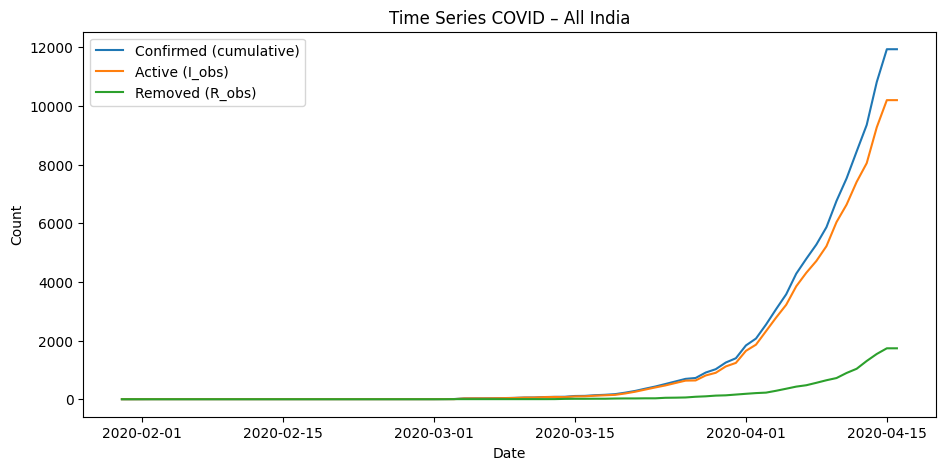

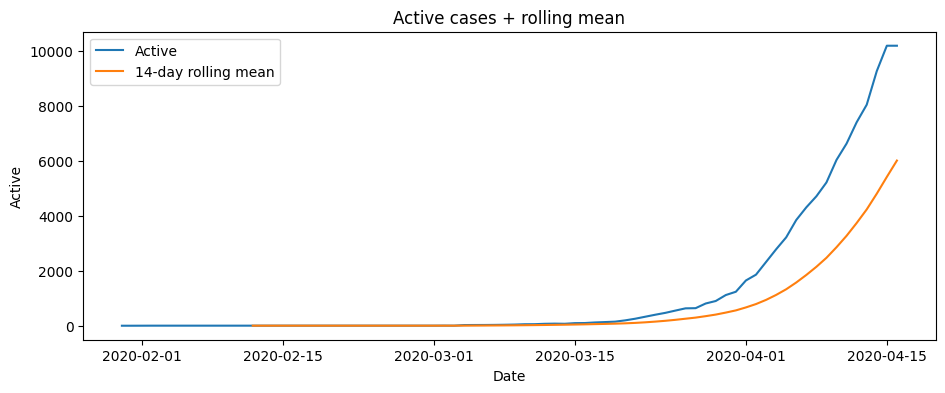

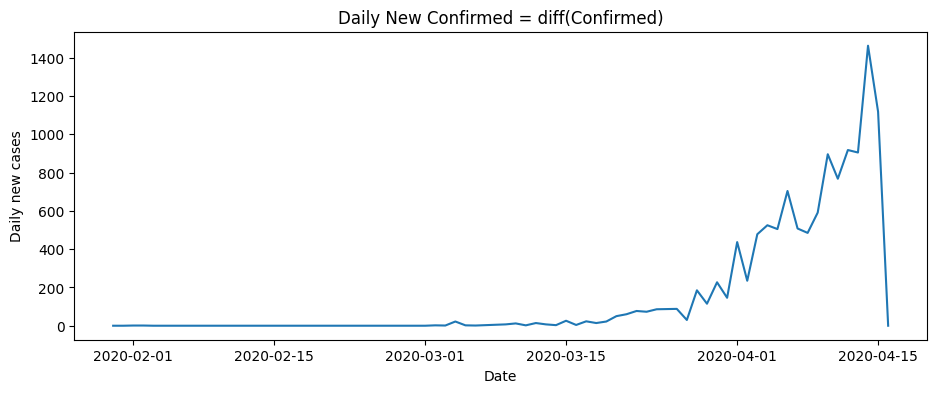

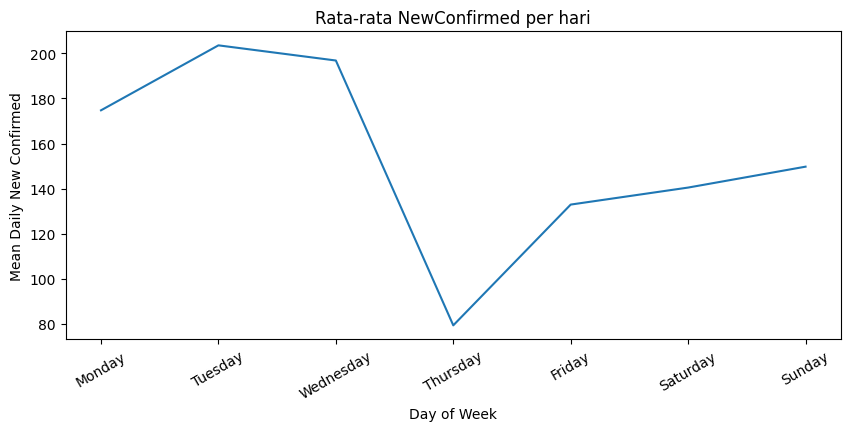

In [4]:
plt.figure(figsize=(11,5))
plt.plot(ts.index, ts["Confirmed"], label="Confirmed (cumulative)")
plt.plot(ts.index, ts["Active"], label="Active (I_obs)")
plt.plot(ts.index, ts["Removed"], label="Removed (R_obs)")
plt.title(f"Time Series COVID – {SCOPE}")
plt.xlabel("Date"); plt.ylabel("Count")
plt.legend()
plt.show()

window = 14
roll = ts["Active"].rolling(window).mean()

plt.figure(figsize=(11,4))
plt.plot(ts.index, ts["Active"], label="Active")
plt.plot(ts.index, roll, label=f"{window}-day rolling mean")
plt.title("Active cases + rolling mean")
plt.xlabel("Date"); plt.ylabel("Active")
plt.legend()
plt.show()

ts["NewConfirmed"] = ts["Confirmed"].diff().fillna(0).clip(lower=0)

plt.figure(figsize=(11,4))
plt.plot(ts.index, ts["NewConfirmed"])
plt.title("Daily New Confirmed = diff(Confirmed)")
plt.xlabel("Date"); plt.ylabel("Daily new cases")
plt.show()

dow = ts.copy()
dow["dayofweek"] = dow.index.day_name()
order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
dow_mean = dow.groupby("dayofweek")["NewConfirmed"].mean().reindex(order)

plt.figure(figsize=(10,4))
plt.plot(dow_mean.index, dow_mean.values)
plt.title("Rata-rata NewConfirmed per hari")
plt.xlabel("Day of Week"); plt.ylabel("Mean Daily New Confirmed")
plt.xticks(rotation=30)
plt.show()


## 3) Formulasi Model SIR (ODE)

Total populasi:
\[
N = S(t) + I(t) + R(t)
\]

Persamaan diferensial:
\[
\frac{dS}{dt} = -\beta \frac{SI}{N},\quad
\frac{dI}{dt} = \beta \frac{SI}{N} - \gamma I,\quad
\frac{dR}{dt} = \gamma I
\]

Metode numerik yang digunakan:
- **Euler**: baseline sederhana
- **RK4**: akurat dan stabil untuk simulasi harian

In [5]:
def sir_deriv(t, y, beta, gamma, N):
    S, I, R = y
    
    if N <= 0:
        raise ValueError("N harus > 0.")
    if beta <= 0 or gamma <= 0:
        raise ValueError("beta dan gamma harus > 0.")

    S = max(float(S), 0.0)
    I = max(float(I), 0.0)
    R = max(float(R), 0.0)

    dS = -beta * S * I / N
    dI = beta * S * I / N - gamma * I
    dR = gamma * I
    return np.array([dS, dI, dR], dtype=float)


# ==========================
# Euler step + simulator
# ==========================
def euler_step(f, t, y, h, *params):
    y = np.asarray(y, dtype=float)
    return y + h * f(t, y, *params)


def simulate_sir_euler(beta, gamma, N, S0, I0, R0, days, h=1.0, conserve=True):
    if days < 1:
        raise ValueError("days minimal 1.")
    if h <= 0:
        raise ValueError("h harus > 0.")
        
    t = np.arange(0, days + 1, h, dtype=float)
    y = np.zeros((len(t), 3), dtype=float)
    y[0] = [S0, I0, R0]

    for i in range(1, len(t)):
        y_next = euler_step(sir_deriv, t[i-1], y[i-1], h, beta, gamma, N)
        y_next = np.maximum(y_next, 0.0)
        if conserve:
            tot = float(y_next.sum())
            if tot > 0:
                y_next = y_next * (float(N) / tot)
        y[i] = y_next

    return t, y


# ==========================
# RK4 step + simulator
# ==========================
def rk4_step(f, t, y, h, *params):
    y = np.asarray(y, dtype=float)

    k1 = f(t, y, *params)
    k2 = f(t + h/2, y + (h/2)*k1, *params)
    k3 = f(t + h/2, y + (h/2)*k2, *params)
    k4 = f(t + h,   y + h*k3,     *params)

    return y + (h/6.0)*(k1 + 2*k2 + 2*k3 + k4)


def simulate_sir_rk4(beta, gamma, N, S0, I0, R0, days, h=1.0, conserve=True):
    if days < 1:
        raise ValueError("days minimal 1.")
    if h <= 0:
        raise ValueError("h harus > 0.")
        
    t = np.arange(0, days + 1, h, dtype=float)
    y = np.zeros((len(t), 3), dtype=float)
    y[0] = [S0, I0, R0]

    for i in range(1, len(t)):
        y_next = rk4_step(sir_deriv, t[i-1], y[i-1], h, beta, gamma, N)
        y_next = np.maximum(y_next, 0.0)
        if conserve:
            tot = float(y_next.sum())
            if tot > 0:
                y_next = y_next * (float(N) / tot)
        y[i] = y_next

    return t, y

## 4) Populasi Total (N) & Kondisi Awal

Dataset tidak memuat N, sehingga N harus didefinisikan dengan jelas:
- Scope (All India / 1 state)
- Tahun N
- Nilai N (integer)
- Sumber resmi (nama + URL)

**Sumber N:** World Bank – Population, total (SP.POP.TOTL)  
https://data.worldbank.org/indicator/SP.POP.TOTL?locations=IN  
Tahun: 2020

In [6]:
N_SOURCE_NAME = "World Bank – Population, total (SP.POP.TOTL)"
N_SOURCE_URL  = "https://data.worldbank.org/indicator/SP.POP.TOTL?locations=IN"
N_YEAR = 2020

POPULATION_LOOKUP = {
    "All India": {2020: 1402617695},
}

if SCOPE not in POPULATION_LOOKUP:
    raise ValueError(f"SCOPE='{SCOPE}' belum ada di POPULATION_LOOKUP.")
if N_YEAR not in POPULATION_LOOKUP[SCOPE]:
    raise ValueError(f"N_YEAR={N_YEAR} belum ada untuk SCOPE='{SCOPE}'.")

N = int(POPULATION_LOOKUP[SCOPE][N_YEAR])

obs = ts[["Active", "Removed"]].copy()
I_obs = obs["Active"].to_numpy(dtype=float)
R_obs = obs["Removed"].to_numpy(dtype=float)

days_total = len(obs) - 1
I0 = float(I_obs[0])
R0_init = float(R_obs[0])
S0 = float(N) - I0 - R0_init

if S0 < 0:
    raise ValueError("S0 < 0. N terlalu kecil dibanding I0 + R0.")

print("=== Populasi N ===")
print("Scope:", SCOPE)
print("Tahun:", N_YEAR)
print("N:", f"{N:,}")
print("Sumber:", N_SOURCE_NAME)
print("URL:", N_SOURCE_URL)

print("\n=== Kondisi awal ===")
print("S0, I0, R0 =", (S0, I0, R0_init))
print("Check total:", S0 + I0 + R0_init)

=== Populasi N ===
Scope: All India
Tahun: 2020
N: 1,402,617,695
Sumber: World Bank – Population, total (SP.POP.TOTL)
URL: https://data.worldbank.org/indicator/SP.POP.TOTL?locations=IN

=== Kondisi awal ===
S0, I0, R0 = (1402617694.0, 1.0, 0.0)
Check total: 1402617695.0


## 5) Split Data TRAIN/TEST

- Train = 80% awal untuk fit parameter (β dan γ)
- Test = 20% akhir untuk evaluasi performa

Dipakai overlap 1 titik pada awal test agar simulasi tetap kontinu.

In [7]:
T = len(I_obs)
train_ratio = 0.8
train_len = int(np.floor(T * train_ratio))

I_train, R_train = I_obs[:train_len], R_obs[:train_len]
I_test,  R_test  = I_obs[train_len-1:], R_obs[train_len-1:]  # overlap 1 titik

# ✅ Tambahan agar metrik train/test di Bagian 7 bisa jalan
train_idx = np.arange(0, train_len)
test_idx  = np.arange(train_len-1, T)  # karena overlap

print("Total titik:", T)
print("Train len:", len(I_train))
print("Test len:", len(I_test))
print("train_idx range:", train_idx[0], "s/d", train_idx[-1])
print("test_idx range:", test_idx[0], "s/d", test_idx[-1])


Total titik: 78
Train len: 62
Test len: 17
train_idx range: 0 s/d 61
test_idx range: 61 s/d 77


## 6) Estimasi Parameter (β dan γ)

Parameter di-fit pada data TRAIN dengan meminimalkan error:
- I(t) = Active
- R(t) = Removed

Metode optimisasi:
- Jika SciPy tersedia → L-BFGS-B
- Jika tidak → grid search

In [8]:
DEBUG = False  # ✅ set True hanya kalau mau lihat detail optimisasi

def loss_beta_gamma_Nfit(params, I0, R0, I_obs_arr, R_obs_arr):
    beta, gamma, N_fit = params

    # batas beta
    if beta <= 0 or beta > 2.0:
        return 1e18

    # ✅ batas gamma realistis (durasi infeksi 5–21 hari)
    gamma_min = 1.0 / 21.0
    gamma_max = 1.0 / 5.0
    if gamma < gamma_min or gamma > gamma_max:
        return 1e18

    I_obs_arr = np.asarray(I_obs_arr, dtype=float)
    R_obs_arr = np.asarray(R_obs_arr, dtype=float)

    IR_max = float(np.max(I_obs_arr + R_obs_arr))
    N_min = 1.05 * IR_max
    N_max = float(min(N, 200.0 * IR_max))  # N = worldbank (metadata)

    if not (N_min <= N_fit <= N_max):
        return 1e18

    S0_fit = N_fit - I0 - R0
    if S0_fit <= 0:
        return 1e18

    # fitting: conserve=False (konsisten & fair)
    _, y = simulate_sir_rk4(
        beta, gamma, N_fit, S0_fit, I0, R0,
        days=len(I_obs_arr) - 1,
        h=1.0,
        conserve=False
    )

    I_pred = np.maximum(y[:, 1], 0.0)
    R_pred = np.maximum(y[:, 2], 0.0)
    I_true = np.maximum(I_obs_arr, 0.0)
    R_true = np.maximum(R_obs_arr, 0.0)

    # ✅ LOG-LOSS lebih stabil (fase eksponensial)
    mse_I = np.mean((np.log1p(I_pred) - np.log1p(I_true))**2)
    mse_R = np.mean((np.log1p(R_pred) - np.log1p(R_true))**2)

    return float(mse_I + mse_R)


# ----- bounds N_fit (dari TRAIN) -----
IR_max_train = float(np.max(I_train + R_train))
N_fit_min = 1.05 * IR_max_train
N_fit_max = float(min(N, 200.0 * IR_max_train))
N_fit0 = float(max(N_fit_min * 1.5, 10.0 * IR_max_train))

# Guard: bounds harus valid
if (not np.isfinite(N_fit_min)) or (not np.isfinite(N_fit_max)) or (N_fit_max <= N_fit_min):
    raise RuntimeError(f"Bounds N_fit tidak valid: min={N_fit_min}, max={N_fit_max}")

gamma_min = 1.0/21.0
gamma_max = 1.0/5.0

if DEBUG:
    print("=== DEBUG BAGIAN 6 ===")
    print("HAS_SCIPY:", HAS_SCIPY)
    print("IR_max_train:", IR_max_train)
    print("N_fit_min:", N_fit_min)
    print("N_fit_max:", N_fit_max)
    print("N_fit0:", N_fit0)
    print("gamma bounds:", (gamma_min, gamma_max))

if HAS_SCIPY:
    # ✅ Multi-start untuk hindari local optimum
    starts = [
        (0.2, 1.0/14.0, max(N_fit_min * 1.5, N_fit0)),
        (0.4, 1.0/10.0, max(N_fit_min * 2.0, N_fit0)),
        (0.8, 1.0/7.0,  max(N_fit_min * 3.0, N_fit0)),
        (1.2, 1.0/5.5,  max(N_fit_min * 4.0, N_fit0)),
    ]

    best_res = None
    best_fun = float("inf")

    for j, (b0, g0, n0) in enumerate(starts, start=1):
        # ✅ pastikan start point masuk bounds (biar optimizer gak “nabrak” dari awal)
        b0 = float(np.clip(b0, 1e-6, 2.0))
        g0 = float(np.clip(g0, gamma_min, gamma_max))
        n0 = float(np.clip(n0, N_fit_min, N_fit_max))

        res = minimize(
            loss_beta_gamma_Nfit,
            x0=np.array([b0, g0, n0], dtype=float),
            args=(I0, R0_init, I_train, R_train),
            bounds=[(1e-6, 2.0), (gamma_min, gamma_max), (N_fit_min, N_fit_max)],
            method="L-BFGS-B",
        )

        if DEBUG:
            print(f"[start {j}] success={getattr(res,'success',None)} fun={getattr(res,'fun',None)} x={getattr(res,'x',None)}")

        if np.isfinite(res.fun) and float(res.fun) < best_fun:
            best_fun = float(res.fun)
            best_res = res

    if best_res is None:
        raise RuntimeError("Fitting gagal: semua start tidak menghasilkan loss finite.")

    beta_hat, gamma_hat, N_fit_hat = map(float, best_res.x)

else:
    raise RuntimeError("SciPy tidak tersedia → Bagian 6 butuh minimize(). Gunakan grid search / install SciPy.")


# Ringkasan hasil
R0_basic = beta_hat / gamma_hat

print("\n=== HASIL FIT (BAGIAN 6) ===")
print("beta_hat:", beta_hat)
print("gamma_hat:", gamma_hat)
print("N_fit_hat:", N_fit_hat)
print("R0 (beta/gamma):", R0_basic)
print("N_fit bounds:", (N_fit_min, N_fit_max))
print("gamma bounds:", (gamma_min, gamma_max))



=== HASIL FIT (BAGIAN 6) ===
beta_hat: 0.1344825947810111
gamma_hat: 0.047619047619047616
N_fit_hat: 13969.999998244966
R0 (beta/gamma): 2.8241344904012333
N_fit bounds: (1466.8500000000001, 279400.0)
gamma bounds: (0.047619047619047616, 0.2)


## 7) Validasi Model (Grafik & Metrik)

Metrik yang dipakai:
- MAE
- RMSE
- MAPE_masked (%) → dihitung hanya saat nilai aktual ≥ 10 untuk mencegah error besar saat data awal kecil.

Validasi dilakukan untuk:
- RK4 (utama)
- Euler (baseline pembanding)

,Method,MAE_I,RMSE_I,MAPE_I_masked(%),MAE_R,RMSE_R,MAPE_R_masked(%)
0,RK4,1124.438500,2599.851268,67.945821,116.635018,313.439989,56.406938
1,Euler,1146.385021,2641.816915,72.690395,126.674741,337.441849,52.579929


,Method,Split,MAE_I,RMSE_I,MAPE_I_masked(%),MAE_R,RMSE_R,MAPE_R_masked(%)
0,RK4,Train,107.038043,254.115152,54.446894,8.755211,12.856958,52.489361
1,RK4,Test,4830.255275,5553.520489,91.145451,506.257332,671.061564,59.148347
2,Euler,Train,112.597382,264.593483,60.930631,8.252579,15.280214,38.020969
3,Euler,Test,4912.822364,5642.304832,92.919816,555.371341,722.429868,67.578756


,Method,MAE_I_test,RMSE_I_test,MAPE_I_test_masked(%),MAE_R_test,RMSE_R_test,MAPE_R_test_masked(%)
0,RK4,4830.255275,5553.520489,91.145451,506.257332,671.061564,59.148347
1,Euler,4912.822364,5642.304832,92.919816,555.371341,722.429868,67.578756


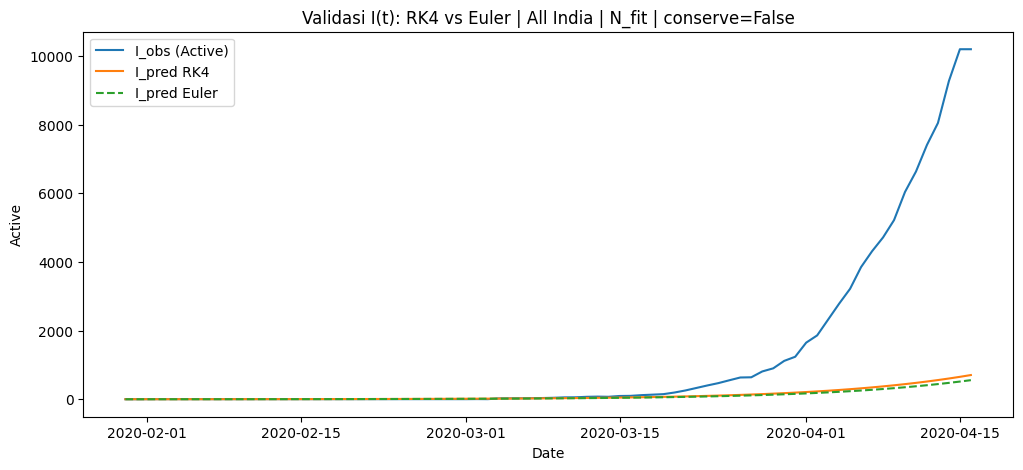

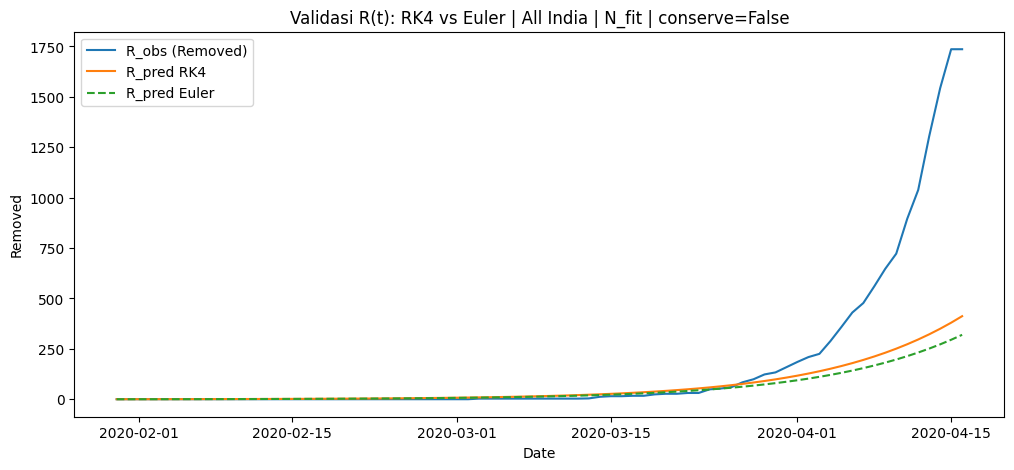

In [9]:
def mae(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    return float(np.mean(np.abs(y_true - y_pred)))

def rmse(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    return float(np.sqrt(np.mean((y_true - y_pred) ** 2)))

def mape_masked(y_true, y_pred, min_true=10.0, eps=1e-9):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    mask = y_true >= float(min_true)
    if int(mask.sum()) == 0:
        return float("nan")
    return float(np.mean(np.abs((y_true[mask] - y_pred[mask]) / (y_true[mask] + eps))) * 100.0)


# =========================
# Simulasi validasi pakai N_fit_hat
# =========================
S0_fit = float(N_fit_hat - I0 - R0_init)
if S0_fit <= 0:
    raise ValueError(
        f"S0_fit <= 0. Cek N_fit_hat={N_fit_hat}, I0={I0}, R0_init={R0_init}. "
        "N_fit_hat harus > I0+R0."
    )

# ✅ FAIR VALIDATION: conserve=False (konsisten dengan fitting)
_, y_rk4 = simulate_sir_rk4(
    beta_hat, gamma_hat,
    N_fit_hat, S0_fit, I0, R0_init,
    days=days_total, h=1.0, conserve=False
)
_, y_eul = simulate_sir_euler(
    beta_hat, gamma_hat,
    N_fit_hat, S0_fit, I0, R0_init,
    days=days_total, h=1.0, conserve=False
)

S_rk4, I_rk4, R_rk4 = y_rk4[:, 0], y_rk4[:, 1], y_rk4[:, 2]
S_eul, I_eul, R_eul = y_eul[:, 0], y_eul[:, 1], y_eul[:, 2]

# Trim supaya panjang prediksi = panjang observasi
T_min = min(len(I_obs), len(I_rk4), len(I_eul))
I_obs_v = np.asarray(I_obs, dtype=float)[:T_min]
R_obs_v = np.asarray(R_obs, dtype=float)[:T_min]
I_rk4_v, R_rk4_v = np.asarray(I_rk4, dtype=float)[:T_min], np.asarray(R_rk4, dtype=float)[:T_min]
I_eul_v, R_eul_v = np.asarray(I_eul, dtype=float)[:T_min], np.asarray(R_eul, dtype=float)[:T_min]

# =========================
# Metrik FULL
# =========================
metrics_compare = pd.DataFrame({
    "Method": ["RK4", "Euler"],
    "MAE_I": [mae(I_obs_v, I_rk4_v), mae(I_obs_v, I_eul_v)],
    "RMSE_I": [rmse(I_obs_v, I_rk4_v), rmse(I_obs_v, I_eul_v)],
    "MAPE_I_masked(%)": [mape_masked(I_obs_v, I_rk4_v), mape_masked(I_obs_v, I_eul_v)],
    "MAE_R": [mae(R_obs_v, R_rk4_v), mae(R_obs_v, R_eul_v)],
    "RMSE_R": [rmse(R_obs_v, R_rk4_v), rmse(R_obs_v, R_eul_v)],
    "MAPE_R_masked(%)": [mape_masked(R_obs_v, R_rk4_v), mape_masked(R_obs_v, R_eul_v)],
})
display(metrics_compare)

# =========================
# Metrik TRAIN vs TEST (jika train_idx/test_idx ada)
# =========================
if "train_idx" in globals() and "test_idx" in globals():
    idx_train = train_idx[train_idx < T_min]
    idx_test  = test_idx[test_idx < T_min]

    def pack_metrics(prefix, y_true, y_pred):
        return {
            f"MAE_{prefix}": mae(y_true, y_pred),
            f"RMSE_{prefix}": rmse(y_true, y_pred),
            f"MAPE_{prefix}_masked(%)": mape_masked(y_true, y_pred),
        }

    rows = []
    for method, I_p, R_p in [
        ("RK4", I_rk4_v, R_rk4_v),
        ("Euler", I_eul_v, R_eul_v),
    ]:
        row_train = {"Method": method, "Split": "Train"}
        row_train.update(pack_metrics("I", I_obs_v[idx_train], I_p[idx_train]))
        row_train.update(pack_metrics("R", R_obs_v[idx_train], R_p[idx_train]))

        row_test = {"Method": method, "Split": "Test"}
        row_test.update(pack_metrics("I", I_obs_v[idx_test], I_p[idx_test]))
        row_test.update(pack_metrics("R", R_obs_v[idx_test], R_p[idx_test]))

        rows.extend([row_train, row_test])

    metrics_split = pd.DataFrame(rows)
    display(metrics_split)

    # =========================
    # ✅ TEST-only table (paling akademik)
    # =========================
    I_obs_test = I_obs_v[idx_test]
    R_obs_test = R_obs_v[idx_test]

    I_rk4_test = I_rk4_v[idx_test]
    R_rk4_test = R_rk4_v[idx_test]

    I_eul_test = I_eul_v[idx_test]
    R_eul_test = R_eul_v[idx_test]

    metrics_test = pd.DataFrame({
        "Method": ["RK4", "Euler"],
        "MAE_I_test": [mae(I_obs_test, I_rk4_test), mae(I_obs_test, I_eul_test)],
        "RMSE_I_test": [rmse(I_obs_test, I_rk4_test), rmse(I_obs_test, I_eul_test)],
        "MAPE_I_test_masked(%)": [mape_masked(I_obs_test, I_rk4_test), mape_masked(I_obs_test, I_eul_test)],
        "MAE_R_test": [mae(R_obs_test, R_rk4_test), mae(R_obs_test, R_eul_test)],
        "RMSE_R_test": [rmse(R_obs_test, R_rk4_test), rmse(R_obs_test, R_eul_test)],
        "MAPE_R_test_masked(%)": [mape_masked(R_obs_test, R_rk4_test), mape_masked(R_obs_test, R_eul_test)],
    })
    display(metrics_test)

# =========================
# Plot
# =========================
dates_plot = obs.index[:T_min]

plt.figure(figsize=(12, 5))
plt.plot(dates_plot, I_obs_v, label="I_obs (Active)")
plt.plot(dates_plot, I_rk4_v, label="I_pred RK4")
plt.plot(dates_plot, I_eul_v, label="I_pred Euler", linestyle="--")
plt.title(f"Validasi I(t): RK4 vs Euler | {SCOPE} | N_fit | conserve=False")
plt.xlabel("Date"); plt.ylabel("Active")
plt.legend(); plt.show()

plt.figure(figsize=(12, 5))
plt.plot(dates_plot, R_obs_v, label="R_obs (Removed)")
plt.plot(dates_plot, R_rk4_v, label="R_pred RK4")
plt.plot(dates_plot, R_eul_v, label="R_pred Euler", linestyle="--")
plt.title(f"Validasi R(t): RK4 vs Euler | {SCOPE} | N_fit | conserve=False")
plt.xlabel("Date"); plt.ylabel("Removed")
plt.legend(); plt.show()